## **Clone Git Repository**

In [8]:
!git clone https://github.com/Rakshith-R/StyleGan_editor.git

Cloning into 'StyleGan_editor'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 123 (delta 4), reused 0 (delta 0), pack-reused 108
Receiving objects: 100% (123/123), 4.55 MiB | 3.20 MiB/s, done.
Resolving deltas: 100% (32/32), done.


## Load feature direction latents


In [0]:
%%capture
%cd /content/StyleGan_editor/
!unzip latent_directions.zip

 Import libraries



In [3]:
%tensorflow_version 1.x
import dnnlib.tflib as tflib
import pretrained_networks
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files
import io
from contextlib import redirect_stdout
import os
import ipywidgets as widgets
import pretrained_networks
from encode_function import encode
model_url='gdrive:networks/stylegan2-ffhq-config-f.pkl'
!mkdir uploaded_images
!mkdir aligned_images
!mkdir generated_images
!mkdir latents
!mkdir image

TensorFlow 1.x selected.


Using TensorFlow backend.


Uploaded images to edit

In [12]:
%cd uploaded_images
uploaded=files.upload() 

/content/StyleGan_editor/uploaded_images


Saving hrithik.jpg to hrithik.jpg
Saving Modi.jpg to Modi.jpg
Saving narendra-modi-gujarat-prime-minister-of-india-narendra-modi.jpg to narendra-modi-gujarat-prime-minister-of-india-narendra-modi.jpg


Aligning images

In [0]:
%%capture
%cd /content/StyleGan_editor/ 
!python align_images.py uploaded_images/ aligned_images/


Encoding images to latent space

In [14]:
%%time
%%capture
tflib.init_tf()
generator=encode('aligned_images/', 'generated_images/', 'latents/')

CPU times: user 1min 36s, sys: 33.4 s, total: 2min 9s
Wall time: 8min 10s


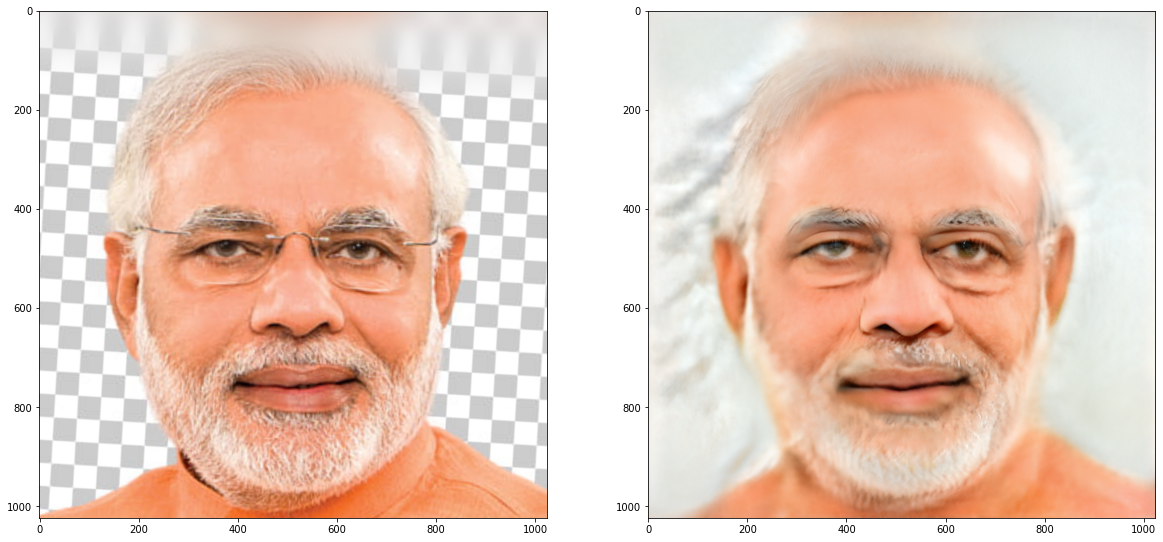

In [27]:
def show(a,b):
    # plt.figure(figsize=(20,20))
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,20))
    # f.figure(figsize=(10,10))
    # f.figure(figsize=(10,10))
    ax1.imshow(a)
    ax2.imshow(b)
    plt.show()
for i in os.listdir("generated_images/"):
    show(cv2.imread("aligned_images/"+i)[:,:,::-1],cv2.imread("generated_images/"+i)[:,:,::-1])

Upload latent vector if any

In [0]:
%cd latents
uploaded=files.upload() 

/content/StyleGan_editor/latents


Saving L1_01.npy to L1_01.npy
Saving L2_01.npy to L2_01.npy
Saving M1_01.npy to M1_01.npy


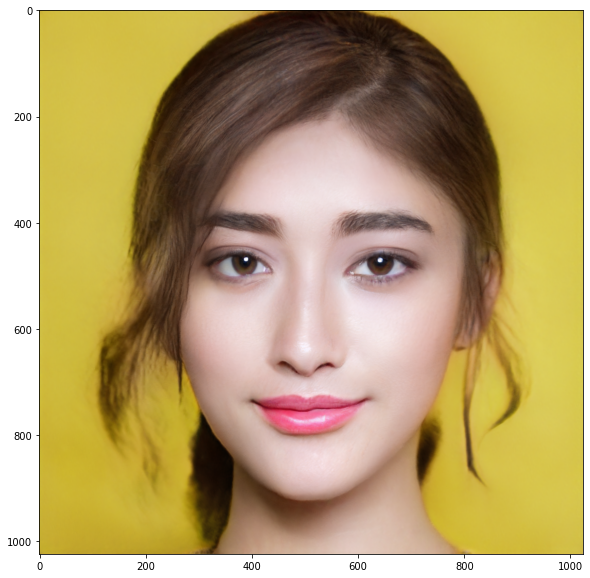

In [0]:
display(output_controls)
widgets.HBox([output_orig,output_image])

In [0]:
output_image=widgets.Output()
output_controls=widgets.Output()
output_orig=widgets.Output()
path_dirc="/content/StyleGan_editor/latent_directions/"
path_lats="/content/StyleGan_editor/latents/"
gen_latents=os.listdir(path_lats)
gen_latents={x[:-4]:np.load(path_lats+x) for x in gen_latents}
directions=os.listdir(path_dirc)
dir_latents={x[:-4]:np.load(path_dirc+x) for x in directions}
selected_np=gen_latents[list(gen_latents.keys())[0]]
Cur_img=None
generator.set_dlatents(selected_np.reshape(1,selected_np.shape[0],selected_np.shape[1]))
Cur_image=generator.generate_images()[0]
output_orig.clear_output()
with output_orig:
    plt.figure(figsize=(10,10))
    plt.imshow(Cur_image)
    plt.show()
drop_image=widgets.Dropdown(
    options=list(gen_latents.keys()),
    value=list(gen_latents.keys())[0],
    description='Choose image to edit:',
    layout=widgets.Layout(width='fit-content',margin='auto'),
    style = {'description_width': 'initial'}

)     
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
drop_dir=widgets.Dropdown(
    options=list(dir_latents.keys()),
    value=list(dir_latents.keys())[0],
    description='Choose feature to change:',
    layout=widgets.Layout(width='fit-content',margin='auto'),
    style = {'description_width': 'initial'}
)
button=widgets.Button(
    description='Generate',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
d1,d2,selc=widgets.Button(
    description='Download Image',
    disabled=False,),widgets.Button(
    description='Download Latent',
    disabled=False,),widgets.Button(
    description='Select',
    disabled=False,)

slid=widgets.FloatSlider( min=-3,max=+3,step=0.005,value=0)
def refresh():
    global selected_np,Cur_image
    output_image.clear_output()
    with output_image:
        plt.figure(figsize=(10,10))
        plt.imshow(Cur_image)
        plt.show()

def changed_img(change):
    global selected_np,Cur_image
    output_image.clear_output()
    output_orig.clear_output()
    selected_np=gen_latents[drop_image.value]
    generator.set_dlatents(selected_np.reshape(1,selected_np.shape[0],selected_np.shape[1]))
    Cur_image=generator.generate_images()[0]
    
    with output_orig:
        plt.figure(figsize=(10,10))
        plt.imshow(Cur_image)
        plt.show()
    refresh()
def edit(change):
    global selected_np,Cur_image
    output_image.clear_output()
    button.disabled=True
    latent=selected_np-slid.value*dir_latents[drop_dir.value]
    selected_np=latent
    generator.set_dlatents(selected_np.reshape(1,selected_np.shape[0],selected_np.shape[1]))
    Cur_image=generator.generate_images()[0]
    slid.value=0
    refresh()
    button.disabled=False   
def download_image(a):
    cv2.imwrite("Generated_image.jpg",Cur_image)
    files.download("Generated_image.jpg")
def download_vector(a):
    np.save("Generated_latent.npy",selected_np)
    files.download("Generated_latent.npy")
d1.on_click(download_image)
d2.on_click(download_vector)
selc.on_click(changed_img)
drop_image.observe(changed_img,names='All')
button.on_click(edit)
output_controls.clear_output()
with output_controls:
    display(widgets.HBox([
                  widgets.VBox([
                       drop_image  ,
                       selc,
                       drop_dir,
                       slid  ,
                       button     
                  ],layout=widgets.Layout(width='fit-content',margin='auto')),
                  widgets.VBox([
                                d1,d2],layout=widgets.Layout(width='fit-content',margin='auto'))

    ]))
refresh()
display(output_controls)
widgets.HBox([output_orig,output_image])